#Pre Processing 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from datetime import date

In [ ]:
!gdown --id 1KiQzNyHGd8KfuGnfjJaETm-vWwNr5YEM
!unzip '/content/mobilidade_estado.zip'

Downloading...
From: https://drive.google.com/uc?id=1KiQzNyHGd8KfuGnfjJaETm-vWwNr5YEM
To: /content/mobilidade_estado.zip
100% 9.54M/9.54M [00:00<00:00, 164MB/s]
Archive:  /content/mobilidade_estado.zip
  inflating: 2022_BR_Region_Mobility_Report.csv  
  inflating: 2020_BR_Region_Mobility_Report.csv  
  inflating: 2021_BR_Region_Mobility_Report.csv  


In [ ]:
# Reading the datasets and merging them
dataset_2020 = pd.read_csv('./2020_BR_Region_Mobility_Report.csv')
dataset_2021 = pd.read_csv('./2021_BR_Region_Mobility_Report.csv')
dataset_2022 = pd.read_csv('./2022_BR_Region_Mobility_Report.csv')

dataset = pd.concat([dataset_2020, dataset_2021, dataset_2022], ignore_index=True)
dataset

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-15,5.0,4.0,-5.0,8.0,6.0,0.0
1,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-16,2.0,3.0,-13.0,3.0,0.0,1.0
2,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-17,-2.0,0.0,-12.0,9.0,19.0,-1.0
3,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-18,-3.0,-1.0,-11.0,9.0,15.0,-1.0
4,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-19,-1.0,-2.0,-5.0,8.0,14.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394999,BR,Brazil,State of Tocantins,Tocantinópolis,NaN,NaN,NaN,ChIJdy1nSeuG2pIR7Nmgv2Wq2uo,2022-01-03,NaN,NaN,NaN,NaN,-6.0,NaN
1395000,BR,Brazil,State of Tocantins,Tocantinópolis,NaN,NaN,NaN,ChIJdy1nSeuG2pIR7Nmgv2Wq2uo,2022-01-04,NaN,NaN,NaN,NaN,-8.0,NaN
1395001,BR,Brazil,State of Tocantins,Tocantinópolis,NaN,NaN,NaN,ChIJdy1nSeuG2pIR7Nmgv2Wq2uo,2022-01-05,NaN,NaN,NaN,NaN,3.0,NaN
1395002,BR,Brazil,State of Tocantins,Tocantinópolis,NaN,NaN,NaN,ChIJdy1nSeuG2pIR7Nmgv2Wq2uo,2022-01-06,NaN,NaN,NaN,NaN,2.0,NaN


In [ ]:
# Removing unnecessary columns
clean_dataset = dataset.drop(['country_region_code', 'country_region', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'], axis=1)
clean_dataset

,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,NaN,NaN,2020-02-15,5.0,4.0,-5.0,8.0,6.0,0.0
1,NaN,NaN,2020-02-16,2.0,3.0,-13.0,3.0,0.0,1.0
2,NaN,NaN,2020-02-17,-2.0,0.0,-12.0,9.0,19.0,-1.0
3,NaN,NaN,2020-02-18,-3.0,-1.0,-11.0,9.0,15.0,-1.0
4,NaN,NaN,2020-02-19,-1.0,-2.0,-5.0,8.0,14.0,-1.0
...,...,...,...,...,...,...,...,...,...
1394999,State of Tocantins,Tocantinópolis,2022-01-03,NaN,NaN,NaN,NaN,-6.0,NaN
1395000,State of Tocantins,Tocantinópolis,2022-01-04,NaN,NaN,NaN,NaN,-8.0,NaN
1395001,State of Tocantins,Tocantinópolis,2022-01-05,NaN,NaN,NaN,NaN,3.0,NaN
1395002,State of Tocantins,Tocantinópolis,2022-01-06,NaN,NaN,NaN,NaN,2.0,NaN


In [ ]:
# Removing rows without information about both state and city
clean_dataset = clean_dataset.dropna(subset=['sub_region_1', 'sub_region_2'], how='all')

# Removing other states
clean_dataset_alagoas = clean_dataset[clean_dataset['sub_region_1'] == 'State of Alagoas']
clean_dataset_alagoas

,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2477,State of Alagoas,NaN,2020-02-15,5.0,3.0,1.0,-9.0,1.0,0.0
2478,State of Alagoas,NaN,2020-02-16,-4.0,0.0,-21.0,-13.0,-1.0,3.0
2479,State of Alagoas,NaN,2020-02-17,-4.0,1.0,-20.0,-7.0,15.0,0.0
2480,State of Alagoas,NaN,2020-02-18,-3.0,-1.0,-18.0,-5.0,14.0,-1.0
2481,State of Alagoas,NaN,2020-02-19,1.0,-1.0,-10.0,-2.0,14.0,-1.0
...,...,...,...,...,...,...,...,...,...
1378074,State of Alagoas,Viçosa,2022-01-04,NaN,NaN,-9.0,NaN,-8.0,NaN
1378075,State of Alagoas,Viçosa,2022-01-05,NaN,NaN,-19.0,NaN,-1.0,NaN
1378076,State of Alagoas,Viçosa,2022-01-06,NaN,NaN,-16.0,NaN,-3.0,NaN
1378077,State of Alagoas,Viçosa,2022-01-07,NaN,NaN,-8.0,NaN,8.0,NaN


In [ ]:
# Function to fill nan values in the column with the median based on the same sub_region_1 and date of the row with missing data

def fill_nan_values(dataset_to_clean, column): 
  dataset_to_clean[column] = dataset_to_clean.groupby(['sub_region_1', 'date'])[column].apply(lambda x: x.fillna(x.mean()))


In [ ]:
# Filling nan values in each column with the median based on the same sub_region_1 and date

columns_to_fill_nan_values = ['retail_and_recreation_percent_change_from_baseline', 
                              'grocery_and_pharmacy_percent_change_from_baseline', 
                              'parks_percent_change_from_baseline',
                              'transit_stations_percent_change_from_baseline',
                              'workplaces_percent_change_from_baseline',
                              'residential_percent_change_from_baseline']

for column in columns_to_fill_nan_values:
  fill_nan_values(clean_dataset_alagoas, column)
  clean_dataset_alagoas[column] = np.round(clean_dataset_alagoas[column], decimals=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
# removing rows that were not updated by the function to fill the nan values in the specific columns
# some groups (of sub_region_1 and date) in some columns does not have any value so they are removed here

#clean_dataset = clean_dataset.dropna(subset=columns_to_fill_nan_values, how='any')
#clean_dataset

In [ ]:
# Check if there is any nan value

for column in columns_to_fill_nan_values:
  if (clean_dataset_alagoas[column].isna().sum() != 0):
    raise Exception('There is a NaN value!')


print('All NaN values removed or updated!')

All NaN values removed or updated!


In [ ]:
# Filtering, cleaning and organizing data from Alagoas

# Removing sub_region_1 and sub_region_2 columns (not too important for data, but the lines below can be removed later)
clean_dataset_alagoas.drop('sub_region_1', inplace=True, axis=1)
clean_dataset_alagoas.drop('sub_region_2', inplace=True, axis=1)

# Getting the mean of the columns for each date to avoid having multiple information for the same date
clean_dataset_alagoas = clean_dataset_alagoas.groupby('date').mean()
clean_dataset_alagoas = clean_dataset_alagoas.reset_index()
clean_dataset_alagoas

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,-12.180833,-4.711250,-14.688333,-4.75,3.000000,-0.200000
1,2020-02-16,-13.750000,-3.000000,-23.847500,-13.25,-0.750000,2.250000
2,2020-02-17,-10.711500,-8.288500,-25.558000,-13.75,15.688000,-0.700000
3,2020-02-18,-10.288571,-8.429524,-20.909524,-6.25,16.061905,-0.700000
4,2020-02-19,-8.378182,-4.570455,-19.090455,-2.75,15.118182,-1.000000
...,...,...,...,...,...,...,...
689,2022-01-04,8.169487,72.000000,-9.100000,52.75,5.052564,4.000000
690,2022-01-05,15.000000,72.830526,-1.700000,59.25,6.027105,3.131316
691,2022-01-06,15.140526,78.859474,2.400000,51.50,7.027105,3.000000
692,2022-01-07,8.621026,62.169487,-9.548718,53.75,13.447436,3.429487


In [ ]:
# Check if there is any nan value

for column in columns_to_fill_nan_values:
  if (clean_dataset_alagoas[column].isna().sum() != 0):
    raise Exception('There is a NaN value!')


print('All NaN values removed or updated!')

All NaN values removed or updated!


In [ ]:
# Checking if there is any missing day

clean_dataset_alagoas['date'] = pd.to_datetime(clean_dataset_alagoas['date'])
 
# Dates which are not in the sequence are returned
my_range = pd.date_range(start="2020-02-15", end="2022-01-08") 
print(my_range.difference(clean_dataset_alagoas['date']))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


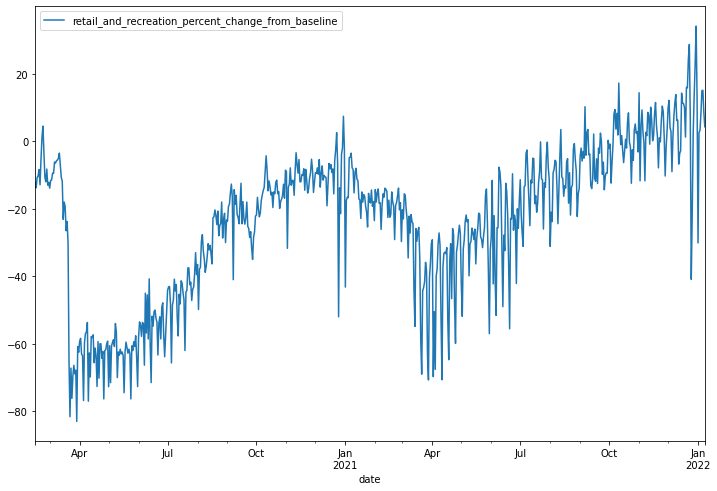

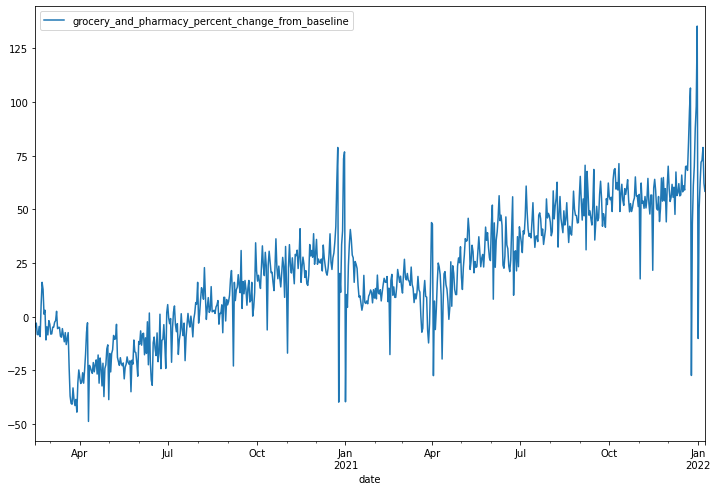

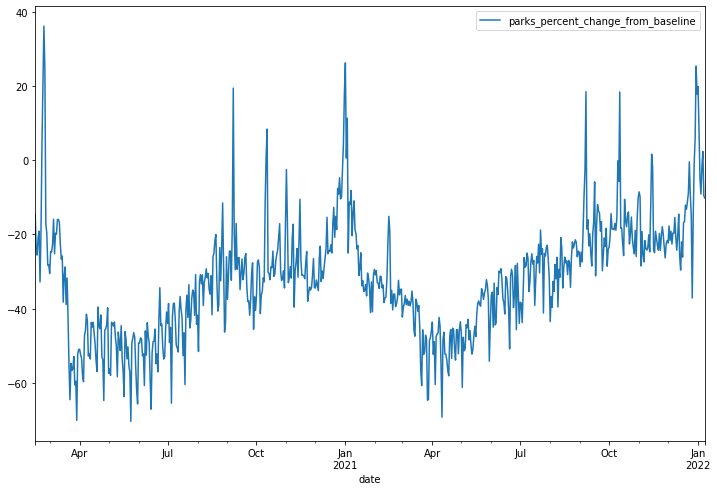

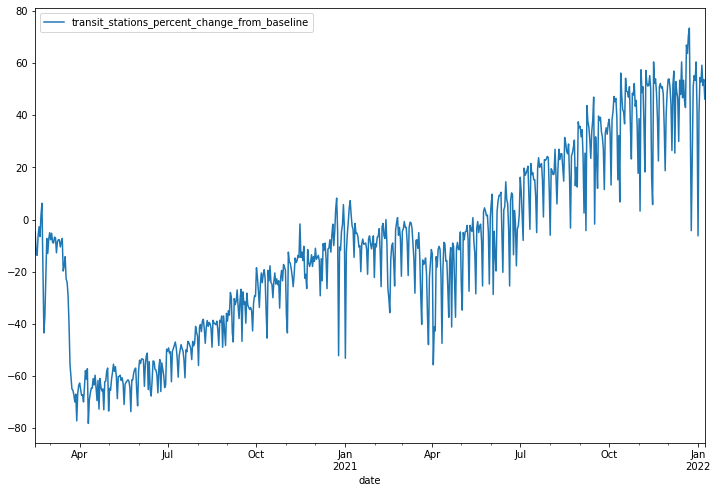

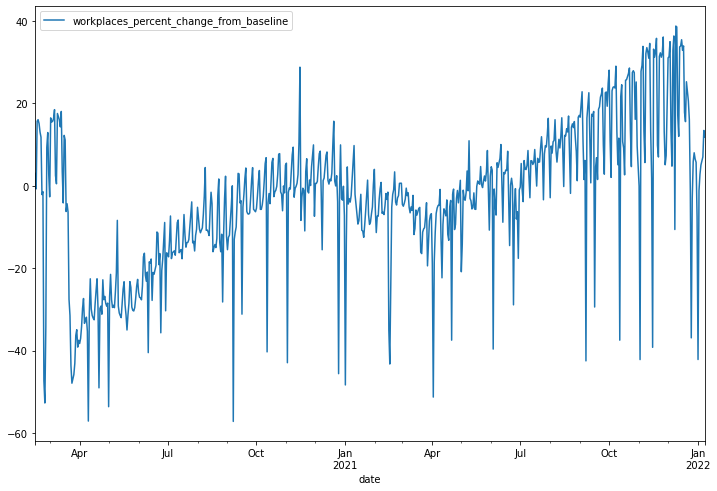

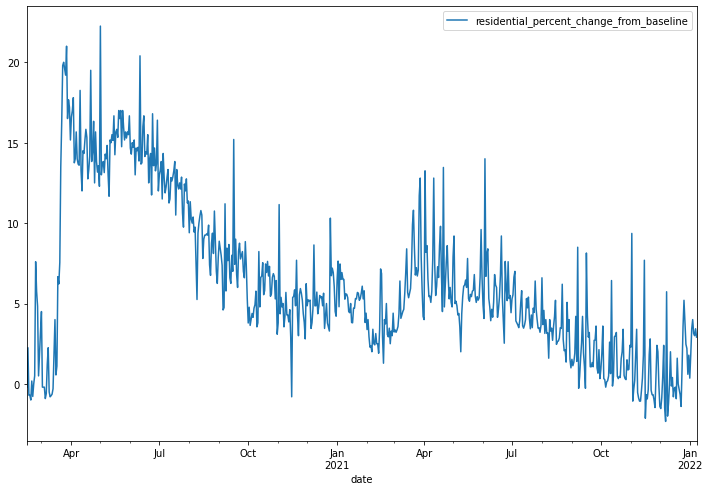

In [ ]:
# Plotting graphs of alagoas

for column in columns_to_fill_nan_values:
  clean_dataset_alagoas.plot(x='date', y=column, figsize=(12, 8))  

In [ ]:
# Downloading bing database about COVID-19
!gdown --id 1UmkJmhKW9stJTAvWx25hZAzJScedmVCE

Downloading...
From: https://drive.google.com/uc?id=1UmkJmhKW9stJTAvWx25hZAzJScedmVCE
To: /content/resultado_bing_covid19_alagoas.csv
100% 21.3k/21.3k [00:00<00:00, 13.7MB/s]


In [ ]:
# Getting bing database about COVID-19 to merge with google database
bin_df = pd.read_csv('/content/resultado_bing_covid19_alagoas.csv')
bin_df

,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange
0,2020-04-08,32,NaN,2.0,NaN
1,2020-04-14,50,3.0,3.0,1.0
2,2020-04-15,72,22.0,4.0,1.0
3,2020-04-16,89,17.0,5.0,1.0
4,2020-04-17,110,21.0,7.0,2.0
...,...,...,...,...,...
593,2022-01-06,242165,0.0,6383.0,0.0
594,2022-01-07,242165,0.0,6383.0,0.0
595,2022-01-08,242165,0.0,6383.0,0.0
596,2022-01-09,242165,0.0,6383.0,0.0


In [ ]:
# Saving google_df before merging

google_df = clean_dataset_alagoas
google_df.to_csv('google_df.csv')
google_df

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,-12.180833,-4.711250,-14.688333,-4.75,3.000000,-0.200000
1,2020-02-16,-13.750000,-3.000000,-23.847500,-13.25,-0.750000,2.250000
2,2020-02-17,-10.711500,-8.288500,-25.558000,-13.75,15.688000,-0.700000
3,2020-02-18,-10.288571,-8.429524,-20.909524,-6.25,16.061905,-0.700000
4,2020-02-19,-8.378182,-4.570455,-19.090455,-2.75,15.118182,-1.000000
...,...,...,...,...,...,...,...
689,2022-01-04,8.169487,72.000000,-9.100000,52.75,5.052564,4.000000
690,2022-01-05,15.000000,72.830526,-1.700000,59.25,6.027105,3.131316
691,2022-01-06,15.140526,78.859474,2.400000,51.50,7.027105,3.000000
692,2022-01-07,8.621026,62.169487,-9.548718,53.75,13.447436,3.429487


In [ ]:
# Changing bin date column to match with google database
bin_df = bin_df.rename(columns={'Updated': 'date'})
bin_df['date'] = pd.to_datetime(bin_df['date'])

# Removing rows in both datasets to have the same interval of days
google_df = google_df.loc[(google_df['date'] >= '2020-04-08') & (google_df['date'] <= '2022-01-08')]
bin_df = bin_df.loc[(bin_df['date'] >= '2020-04-08') & (bin_df['date'] <= '2022-01-08')]

google_df

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
53,2020-04-08,-56.500000,-7.250000,-41.500000,-61.25,-31.893913,13.669130
54,2020-04-09,-53.669167,-2.859167,-43.200000,-57.25,-35.350000,13.600000
55,2020-04-10,-77.000000,-48.830690,-52.800000,-78.25,-57.115862,18.250000
56,2020-04-11,-62.700000,-22.711250,-52.236667,-69.25,-31.061667,13.250000
57,2020-04-12,-69.830909,-23.750000,-53.561818,-66.75,-22.570909,12.000000
...,...,...,...,...,...,...,...
689,2022-01-04,8.169487,72.000000,-9.100000,52.75,5.052564,4.000000
690,2022-01-05,15.000000,72.830526,-1.700000,59.25,6.027105,3.131316
691,2022-01-06,15.140526,78.859474,2.400000,51.50,7.027105,3.000000
692,2022-01-07,8.621026,62.169487,-9.548718,53.75,13.447436,3.429487


In [ ]:
# Merging both datasets (google and bin)
alagoas_df = pd.merge(bin_df, google_df, on='date')
alagoas_df = alagoas_df.round(decimals=2)

# Removing two irrelevants features
alagoas_df.drop(['ConfirmedChange', 'DeathsChange'], axis=1, inplace=True)

# Saving alagoas dataset
alagoas_df.to_csv('alagoas_covid_mobility_database')
alagoas_df

,date,Confirmed,Deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-04-08,32,2.0,-56.50,-7.25,-41.50,-61.25,-31.89,13.67
1,2020-04-14,50,3.0,-58.17,-26.43,-45.00,-64.75,-31.47,14.33
2,2020-04-15,72,4.0,-57.33,-21.38,-43.70,-61.00,-32.11,15.17
3,2020-04-16,89,5.0,-65.60,-25.71,-46.75,-63.50,-32.53,15.83
4,2020-04-17,110,7.0,-61.25,-22.43,-49.53,-59.75,-28.71,15.33
...,...,...,...,...,...,...,...,...,...
591,2022-01-04,242108,6383.0,8.17,72.00,-9.10,52.75,5.05,4.00
592,2022-01-05,242165,6383.0,15.00,72.83,-1.70,59.25,6.03,3.13
593,2022-01-06,242165,6383.0,15.14,78.86,2.40,51.50,7.03,3.00
594,2022-01-07,242165,6383.0,8.62,62.17,-9.55,53.75,13.45,3.43


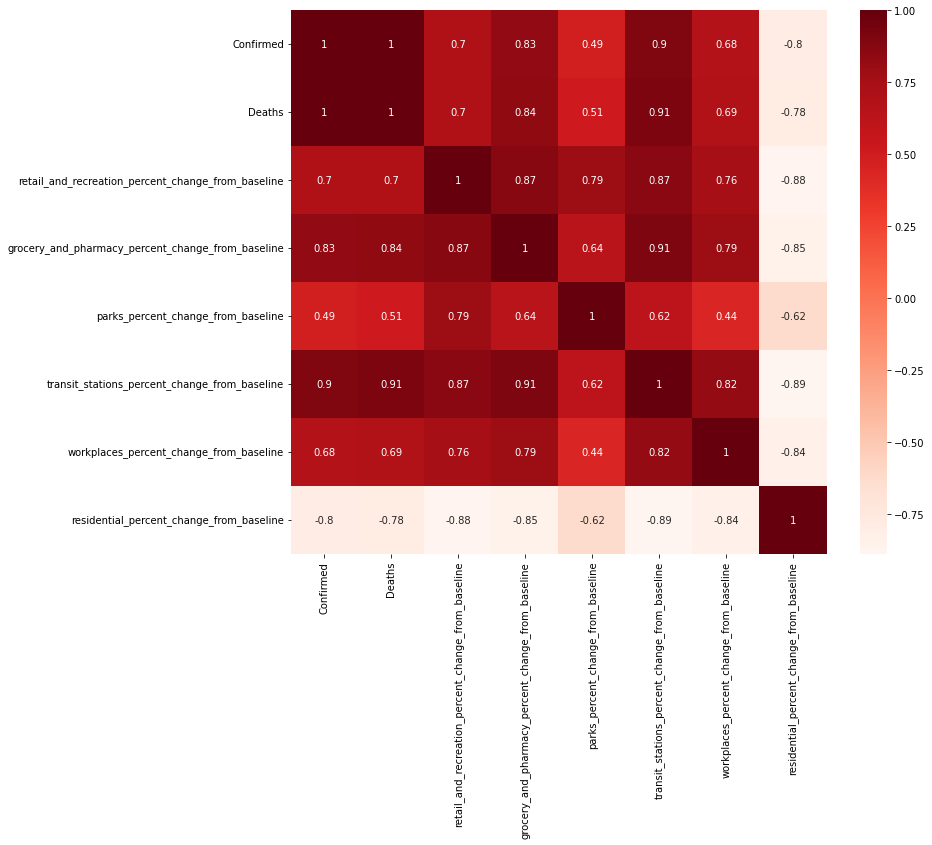

In [ ]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = alagoas_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Correlation with 'Confirmed' Feature
cor_target = abs(cor['Confirmed'])

# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]

# Removing unnecessary features
relevant_features.drop(['Confirmed', 'Deaths'], inplace=True)
relevant_features

retail_and_recreation_percent_change_from_baseline    0.698444
grocery_and_pharmacy_percent_change_from_baseline     0.834281
transit_stations_percent_change_from_baseline         0.904011
workplaces_percent_change_from_baseline               0.681478
residential_percent_change_from_baseline              0.796118
Name: Confirmed, dtype: float64

## Calculating Feature Importance

In [ ]:
# Dividing data in train and test
X = alagoas_df.copy()
X.drop(['date', 'Deaths', 'Confirmed'], axis=1, inplace=True)
y = alagoas_df['Confirmed'].copy() 

In [ ]:
# Creating, training and testing model with k-fold cross validation
rf = RandomForestRegressor(n_estimators=100)
cv = model_selection.KFold(n_splits=10)

mean_squared_error = []
R2_score = []

# Validating with k-fold cross validation
for train_index, test_index in cv.split(X):
    # Selecting train and test data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    rf.fit(X_train, y_train)

    # Default metric is R2
    rf.score(X_test, y_test)
 
    # For other metrics, we need the predictions of the model
    y_pred = rf.predict(X_test)


    # Checking accuracy 
    mean_squared_error.append(metrics.mean_squared_error(y_test, y_pred))
    R2_score.append(metrics.r2_score(y_test, y_pred))

# Printing accuracy
print('R2 Score: ' + str(sum(R2_score) / len(R2_score)))
print('Mean Squared Error: ' + str(sum(mean_squared_error) / len(mean_squared_error)))

# Training the model
rf.fit(X, y)

R2 Score: -334.1246460776226
Mean Squared Error: 1179567013.092145


RandomForestRegressor()

Text(0.5, 0, 'Random Forest Feature Importance')

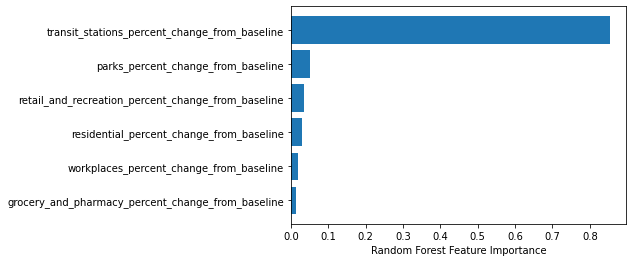

In [ ]:
# Checking random forest algorithm for feature importance
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
# Using Permutation importance
perm_importance = permutation_importance(rf, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

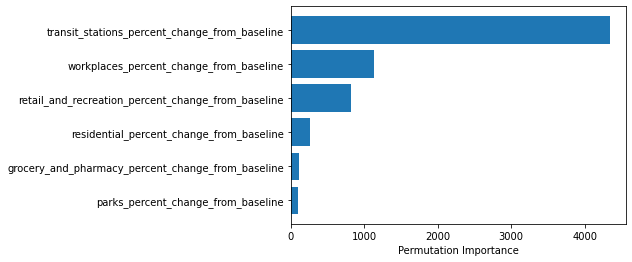

In [ ]:
# Plotting the graph of permutation importance for the features
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")